Reproducing the solution for linear regression proposed in [vector quantile regression: an optimal transport approach](https://arxiv.org/pdf/1406.4643). There is no code provided for this article.

Shape of x: (1000, 1)
Shape of y: (1000, 2)
Min x value: 0.50, Max x value: 2.50


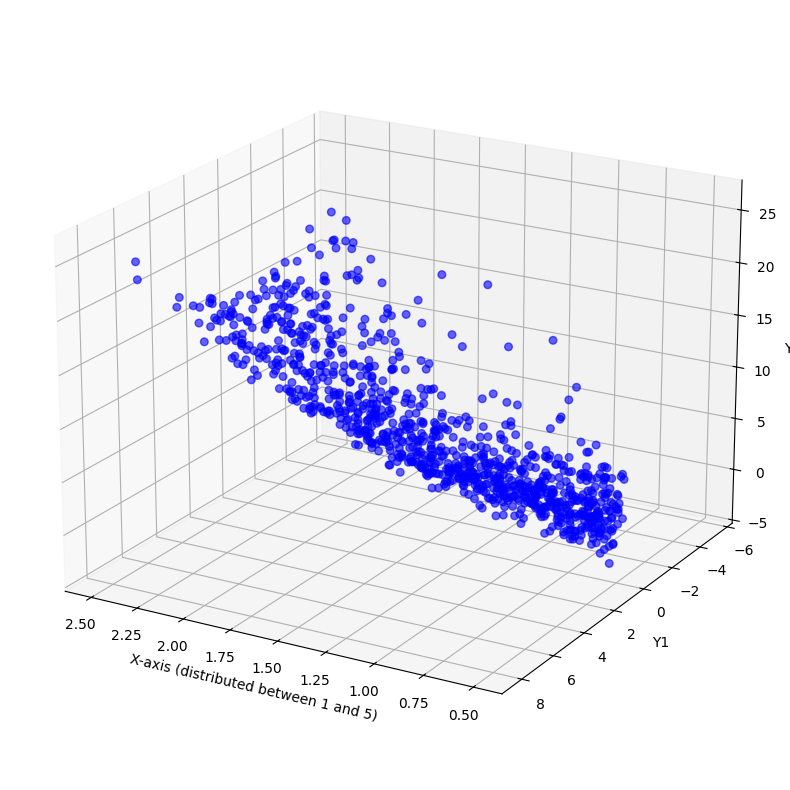

In [1]:
from data_utils import create_joint_x_y, create_conditional_x
import numpy as np
import matplotlib.pyplot as plt

num_points_to_generate = 1000
x, y = create_joint_x_y(num_points_to_generate)

print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")
print(f"Min x value: {np.min(x):.2f}, Max x value: {np.max(x):.2f}")


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x[:,0 ], y[:, 0], y[:, 1], c='blue', marker='o', s=30, alpha=0.6)

ax.set_xlabel('X-axis (distributed between 1 and 5)')
ax.set_ylabel('Y1')
ax.set_zlabel('Y2')

ax.grid(True)
ax.view_init(elev=20, azim=120)

plt.show()

In [2]:
import numpy as np
from scipy.optimize import linprog

def solve_vqr_primal(Y, X, U, nu, mu):
    """
    Solves the primal form of the Vector Quantile Regression (VQR) linear program.

    This function implements the discrete formulation of the VQR problem as
    described in equation (4.1) of "VECTOR QUANTILE REGRESSION" by
    G. Carlier, V. Chernozhukov, and A. Galichon.

    Args:
        Y (np.ndarray): The n x q matrix of response variables.
        X (np.ndarray): The n x p matrix of regressors.
        U (np.ndarray): The m x q matrix of points for the reference distribution.
        nu (np.ndarray): The n x 1 vector of probability weights for observations (Y, X).
        mu (np.ndarray): The m x 1 vector of probability weights for the reference points U.

    Returns:
        scipy.optimize.OptimizeResult: The result object from scipy.optimize.linprog.
        The optimal `pi` matrix can be recovered by `res.x.reshape((n, m)).T`.
    """
    n, _ = Y.shape
    m, _ = U.shape

    UY_transpose = U @ Y.T
    c = -UY_transpose.flatten('F')

    # Constraint (a): Marginal distribution of (X, Y) is nu.
    A_eq_a = np.kron(np.eye(n), np.ones((1, m)))

    E_X = nu.T @ X
    mu_EX = mu @ E_X

    A_eq_b = np.kron(X.T, np.eye(m))
    b_eq_b = mu_EX.flatten('F')

    A_eq = np.vstack([A_eq_a, A_eq_b])
    b_eq = np.concatenate([nu.flatten(), b_eq_b])

    bounds = (0, None)

    print("Solving the linear program...")
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    return res

Sampling has to be from the grid, otherwise we can not compute the derivative

In [3]:
num_points_to_generate = 750
num_latent_points_to_generate = 750

X, Y = create_joint_x_y(num_points_to_generate)
X = np.concatenate([X, np.ones((num_points_to_generate, 1))], axis=1)

n, d = Y.shape
U = np.random.normal(size=(num_latent_points_to_generate, d))
m = U.shape[0]

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

result = solve_vqr_primal(Y, X, U, nu, mu)

Solving the linear program...


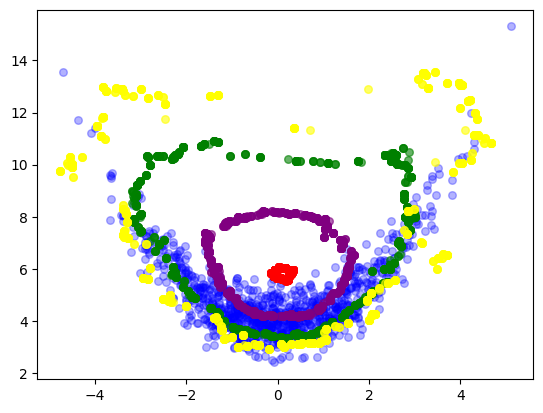

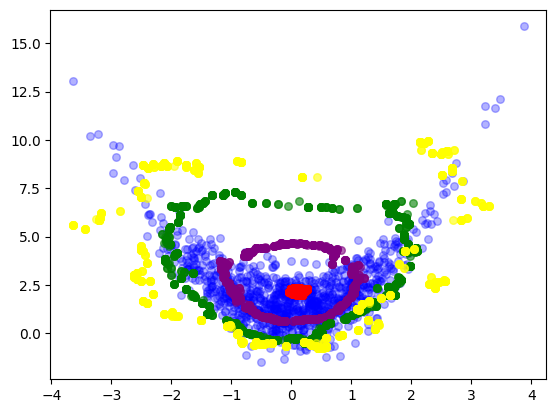

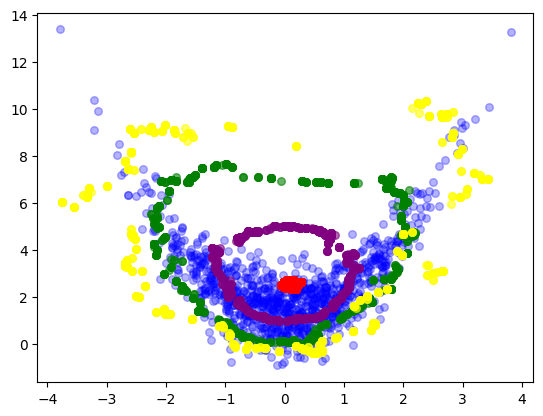

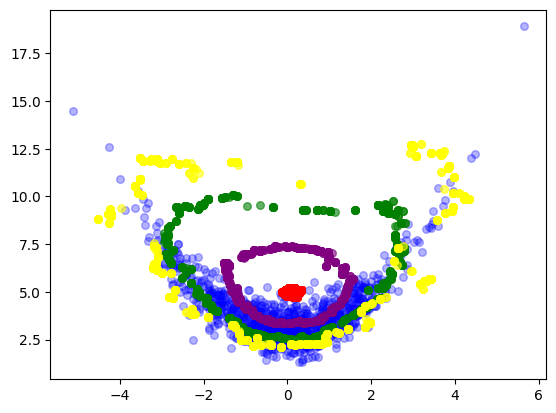

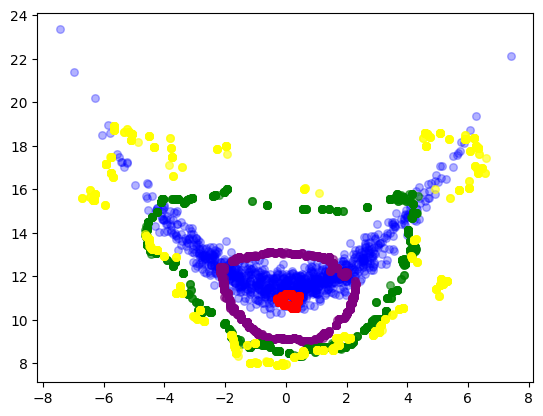

In [5]:
%matplotlib inline

from jaccobian_utils import estimate_gradients_for_points_knn

for X_index in range(0, 500, 100):
    x = X[X_index, :]
    _, y_x_gt = create_conditional_x(n_points=1000, x_value=x[0])
    plt.scatter(y_x_gt[:, 0], y_x_gt[:, 1], color='blue', marker='o', s=30, alpha=0.3)

    for contour_radius, color in zip(
        [0.1, 1, 2, 3],
        ['red', 'purple', 'green', 'yellow']
    ):
        pi = np.random.uniform(-np.pi, np.pi, 1000)
        u = np.stack([
            contour_radius*np.cos(pi),
            contour_radius*np.sin(pi),
        ])

        b_u = result.eqlin['marginals'][num_points_to_generate:].reshape((U.shape[0], X.shape[1]), order='F')
        phi_u = - b_u @ x

        pushforward_of_u = estimate_gradients_for_points_knn(U, phi_u, points_of_interest=u.T, k=10)
        plt.scatter(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, marker='o', s=30, alpha=0.6)

    plt.show()